# Método de interpolación de Kriging
Esta notebook muestra el comportamiento del método de interpolación de Kriging en una dimension.

In [1]:
import pymysql.cursors
import pandas as pd

# Connect to the database
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='root',
                             database='PA',
                             cursorclass=pymysql.cursors.DictCursor)

with connection.cursor() as cursor:
    cursor.execute("SELECT DISTINCT Estacion FROM presionatmosferica")
    result_est = cursor.fetchall()
    cursor.execute("SELECT DISTINCT Parametro FROM presionatmosferica")
    result_par = cursor.fetchall()
    #cursor.close()
    cursor.execute("SELECT DISTINCT Parametro FROM presionatmosferica")
    result_par = cursor.fetchall()
    cursor.close()


estaciones = pd.DataFrame(result_est)
parametros = pd.DataFrame(result_par)
QuerySerial = [[i, estaciones.Estacion.iloc[i], parametros.Parametro.iloc[j]]for i in range(len(estaciones)) for j in range(len(parametros))]
QuerySerial

[[0, 'AJM', 'PA'],
 [1, 'CUT', 'PA'],
 [2, 'HGM', 'PA'],
 [3, 'INN', 'PA'],
 [4, 'LAA', 'PA'],
 [5, 'MER', 'PA'],
 [6, 'MON', 'PA'],
 [7, 'MPA', 'PA'],
 [8, 'TLA', 'PA'],
 [9, 'XAL', 'PA']]

Con la coneccion establecida y las solicitudes ejecutadas podemos cargar una serie temporal a un Data Frame para poder filtrar fácilmente los datos 
faltantes

In [2]:
ConsultaV = 'SELECT Valor FROM presionatmosferica WHERE Estacion=' + QuerySerial[1][1] + ' ORDER BY FechaDEC ASC'
# este es un ejemplo de una serie temporal y la solicitúd que se hace al 
# curosor para imoprtarla desde la base de datos
ConsultaV

'SELECT Valor FROM presionatmosferica WHERE Estacion=CUT ORDER BY FechaDEC ASC'

In [7]:
import time
import pymysql.cursors
import mysql.connector
import pandas as pd
import numpy as np
import math
import random
from random import sample
from sympy import *
ConsultaV = 'SELECT FechaDEC, Valor FROM presionatmosferica WHERE Estacion="' + QuerySerial[0][1] + '" ORDER BY FechaDEC ASC'
print(ConsultaV)
with connection.cursor() as cursor:

    #ConsultaV = 'SELECT Valor FROM presionatmosferica WHERE Estacion=' + QuerySerial[0][1] + ' ORDER BY FechaDEC ASC'
    cursor.execute(ConsultaV)
    Valor = cursor.fetchall()
# cargamos los datos en un dataframe
Datos = pd.DataFrame(Valor)
# y comenzamos a filtrar y separar los valores faltantes de los llenos.

Datos['Valor'] = pd.to_numeric(Datos['Valor'], errors='coerce')
Datos['FechaDEC'] = pd.to_numeric(Datos['FechaDEC'], errors='coerce')
llenos = Datos.dropna()
huecos = Datos[Datos.isnull().values]

# Este valor corresponde a el tamaño del muestreo.
nkrig = 24 * 7


SELECT FechaDEC, Valor FROM presionatmosferica WHERE Estacion="AJM" ORDER BY FechaDEC ASC


/home/ars/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

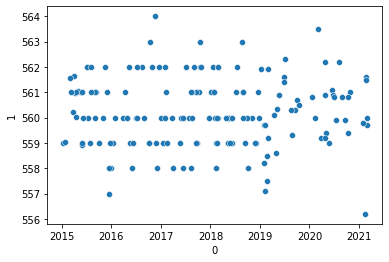

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
U = [llenos.iloc[random.randrange(1, len(llenos))].tolist() for n in range(nkrig)]
forplot = pd.DataFrame(U)
sns.scatterplot(forplot[0], forplot[1])
# plot de los datos llenos.

/home/ars/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='FechaDEC', ylabel='Valor'>

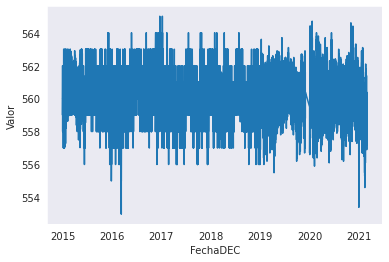

In [5]:
import matplotlib.pyplot as plt
sns.set_style("dark")

sns.lineplot(llenos['FechaDEC'], llenos['Valor'])


El método de interpolación de kriging consiste en resolver un sistema de ecuaciónes que calcula el valor faltante a través de una matriz construida sobre un variograma contruido con un sampleo de los datos disponibles.

/home/ars/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

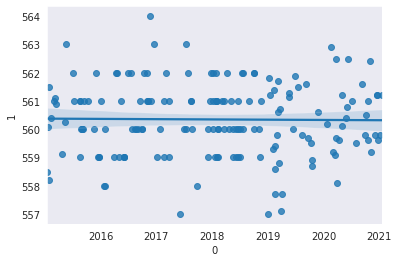

In [8]:
sampl = sample([x for x in range(0,len(llenos))], 24*7)
U = [llenos.iloc[sampl[n]].tolist() for n in range(24*7)]
df = pd.DataFrame(U)
sns.set_style("dark")
sns.regplot(df[0], df[1])

In [ ]:
time_start = time.time()
ubic = [float(huecos.iloc[1].FechaDEC), 1]
U = [llenos.iloc[random.randrange(1, len(llenos))].tolist() for n in range(nkrig)]
dim = len(U)
U.append(ubic)
Distances = [[math.dist(U[i],U[j]) for i in range(len(U))] for j in range(len(U))]
S = ones(dim+1, dim+2)
D = Matrix(Distances)
S[0:dim, 0:dim] = D[0:dim, 0:dim]
S[dim, dim] = 0.0
S[0:dim, dim+1] = D[0:dim, dim]
Sol, _ = S.rref()
#Sol[0:dim, dim+1]
Vals = S[0:dim, dim+1]
result = (Sol[0:dim, dim+1].T * Vals)[0]
print(float(sum(vals)))
d_t = time.time() - time_start
d_t

Utilizando la librería sympy podemos resolver la matriz y obtener un resultado estimado,lo cual está bien, sin embargo, considerando la cantidad de datos que se desean interpolar, este tiempo no es una opción.

In [13]:
import statistics
for i in range(10):
    time_start = time.time()
    ubic = [float(huecos.iloc[243].FechaDEC), 0]
    U = [llenos.iloc[random.randrange(1, len(llenos))].tolist() for n in range(nkrig)]
    dim = len(U)
    M = U.copy()
    M.append(ubic)
    Distances = [[math.dist(M[i],M[j]) for i in range(dim+1)] for j in range(dim+1)]
    S = np.array([[1.0 for i in range(dim+2)] for j in range(dim+1)])
    D = np.array(Distances)
    S[0:dim, 0:dim] = D[:dim,:dim]
    S[dim, dim] = 0.0
    S[0:dim, dim+1] = D[0:dim, dim]
    a = S[:dim+1, :dim+1]
    b = S[0:dim+1, dim+1]
    Sol = np.linalg.solve(a, b)
    experi = S[0:dim, dim+1]
    result = np.dot(Sol[:dim], experi)
    d_t = time.time() - time_start
    
    print(result, d_t, statistics.mean(b))


559.2481371112153 0.1559293270111084 557.8927559535506
512.0 0.07047677040100098 557.7879062133194
556.9702930653314 0.08952617645263672 557.8909719135909
556.7105694505476 0.1251835823059082 557.9513946634534
556.3851897703364 0.08380913734436035 557.968715489849
556.489711197079 0.06838107109069824 557.6168210514445
-273.88133354045567 0.06416630744934082 557.8367066398536
557.0431331471489 0.08815813064575195 557.8045625707116
724.7213599423121 0.07333874702453613 557.8330256729927
553.8862324100782 0.07666587829589844 557.7542945725671


Existen sampleos en los que el variograma no es adecuado, provocando resultados sin sentido. Haciendo una restriccion de este, podemos medir mejor el comportamiento y el tiempo de compilación.

In [ ]:
import math
import numpy as np
def np_method(U, ubic):
    """
    Se construye la matriz de unos y se remplazan el primer bloque
    con la matriz de distancias, se calcula la solución del sistema
    de ecuaciones resultante.
    
    Parameters
    ----------
    U : List
        Lista de dos dimensiones [[], ..., []] que contiene las observaciones
        usadas para construir el sistema de ecuaciones
    
    ubic : List
        Lista de posicion ['fecha', 0] en la cuál se va a calcular el valor del parametro.
        
    Returns
    -------
    float
        Valor interpolado.
    """
    dim = len(U)
    U.append(ubic)
    #Distances = [[math.dist(U[i],U[j]) for i in range(dim+1)] for j in range(dim+1)]
    S = np.array([[1.0 for i in range(dim+2)] for j in range(dim+1)])
    D = np.array([[math.dist(U[i],U[j]) for i in range(dim+1)] for j in range(dim+1)])
    S[0:dim, 0:dim] = D[:dim,:dim]
    S[dim, dim] = 0.0
    S[0:dim, dim+1] = D[0:dim, dim]
    a = S[:dim+1, :dim+1]
    b = S[0:dim+1, dim+1]
    Sol = np.linalg.solve(a=a, b=b)
    experi = S[0:dim, dim+1]
    result = np.dot(Sol[:dim], experi)
    return result

In [27]:
ubic = [2018, 0]
time_start = time.time()
while True:
    try:
        U = [llenos.iloc[random.randrange(1, len(llenos))].tolist() for n in range(nkrig)]
        out = np_method(U, ubic)
        if (out > 500) and (out < 600):
            break
        else: pass
        
    except np.linalg.LinAlgError:
        pass
d_t = time.time() - time_start
print(out, d_t)

553.8739148683444 0.1934061050415039


Para pasar a la arquitectura de una GPU necesitamos introducir los datos como tensores, para ello es necesario automatizar el proceso anterior.


In [28]:
nkrig = 24*7
for i in range(10):
    if i % 10 == 0:
        print('Estado: nivel {} iteracion {} de {} a las {}'.format(0, i, len(huecos), time.strftime('%H:%M:%S', time.localtime())))
    ubic = [huecos.iloc[i].FechaDEC, 0]
    time_start = time.time()
    while True:
        try:
            U = [llenos.iloc[random.randrange(1, len(llenos))].tolist() for n in range(nkrig)]
            out = np_method(U, ubic)
            if (out > 500) and (out < 600):
                break
            else: pass
        except np.linalg.LinAlgError:
            pass
    d_t = time.time() - time_start
    print(out, d_t)

Estado: nivel 0 iteracion 0 de 254970 a las 17:14:35
556.9943370065532 0.10404825210571289
555.4635676153675 0.21288490295410156
555.6341815303267 0.059310197830200195
556.919697561879 0.05930781364440918
553.6827778509249 0.061986446380615234
556.9173189037488 0.08387875556945801
556.125270440436 0.06186699867248535
557.3430076372296 0.06011629104614258
553.6756824832523 0.05983853340148926
557.3585993766073 0.08116269111633301


De la forma anterior podemos inferir la forma en la que construiríamos una estructura que contenga todos los sistemas de ecuaciones que deseamos resolver.

In [1]:
def get_components():
    """
    Se construye la matriz de unos y se remplazan el primer bloque
    con la matriz de distancias, se calculan los componenetes de la ecuación
    AX=B.
    
    Parameters
    ----------
    U : List
        Lista de dos dimensiones [[], ..., []] que contiene el sampleo
    
    ubic : List
        Lista de posicion ['fecha', 0] en la cuál se va a calcular el valor del parametro.
        
    Returns
    -------
    matr, equ, to_mult: lists
        Componentes de la ecuación AX=B
        
    """
    dim = len(U)
    U.append(ubic)
    #Distances = [[torch.dist(torch.tensor(U[i]), torch.tensor(U[j]), 2).item() for i in range(dim+1)] for j in range(dim+1)]
    Distances = [[float(np.linalg.norm((U[i][0]-U[j][0],U[i][1]-U[j][1]))) for i in range(dim+1)] for j in range(dim+1)]
    S = np.array([[1.0 for i in range(dim+2)] for j in range(dim+1)])
    D = np.array(Distances)
    S[0:dim, 0:dim] = D[:dim,:dim]
    S[dim, dim] = 0.0
    S[0:dim, dim+1] = D[0:dim, dim]
    matr = S[:dim+1, :dim+1]
    equ = S[0:dim+1, dim+1]
    to_mult = S[:dim, dim+1]
    return matr, equ, to_mult

Forma vectorizada de la solución de N sistemas de ecuaciones

In [ ]:
matrices = []
equals = []
to_multi = []
timein = time.time()
for i in range(500):
  if i%100==0:
    print(i, time.time()-timein)
   # print(i, time.time() - partial)
  ubic = [huecos.iloc[i].FechaDEC, 0]
  while True:
      # calculamos el muestreo y las matrices y vectores.
      sampl = sample([x for x in range(0,len(llenos))], 24*7)
      U = [llenos.iloc[sampl[n]].tolist() for n in range(24*7)]
      matr, equ, to_mul = get_components(ubic, U)
      if np.linalg.det(matr)>0.0:
        partial = time.time()
        to_multi.append(to_mul)
        matrices.append(matr)
        equals.append(equ)
        break
      else: pass


A = torch.tensor(matrices)
b = torch.tensor(equals)
soluciones = torch.linalg.solve(A, b)
print(soluciones[:torch.tensor(to_multi).shape[1]].shape)
print(torch.tensor(to_multi).shape)
reemplazo = [torch.dot(soluciones[i][:torch.tensor(to_multi).shape[1]], torch.tensor(to_multi)[i]).item() for i in range(A.shape[0])]
timefin = time.time() - timein
print(timefin)

Forma lineal de la solución de N sistemas de ecuaciones 

In [ ]:
nkrig = 24*7

for i in range(100):
    #if i % 10 == 0:
    #    print('Estado: nivel {} iteracion {} de {} a las {}'.format(0, i, len(huecos), time.time()))
    ubic = [huecos.iloc[i].FechaDEC, 0]
    time_start = time.time()
    while True:
        try:
          sampl = sample([x for x in range(0,len(llenos))], 24*7)
          U = [llenos.iloc[sampl[n]].tolist() for n in range(24*7)]
          matr, equ, to_mul = get_components(ubic, U)
          #part1 = time.time()
          #print('det', np.linalg.det(matr))
          #print('parcial', i, time.time()-time_start)
          if np.linalg.det(matr)>0.0:
            A = torch.tensor(matr)
            b = torch.tensor(equ)
            solucion = torch.linalg.solve(A, b)
            result = torch.dot(solucion[:len(to_mul)], torch.tensor(to_mul)).item()
            #print('result', result)
            if result>500 and result<600:
              out = result
              partial = time.time()
              #print(i)
              break
            else: pass
          else: pass
        except RuntimeError:
            pass
    Datos.loc[huecos.iloc[i].name, 'Valor'] = out
    d_t = time.time() - time_start
    print(out, d_t)
print(d_t)

Una vez obtenidos los datos interpolados procedemos a actualizar el Dataframe

In [ ]:
for i in range(len(huecos)):
    Datos.loc[Datos[Datos.isnull().values].index[i], 'Valor'] = reemplazo[i]
